### Setup

In [2]:
import os
import osmnx as ox
import networkx as nx
from graph_search import *
import networkx as nx

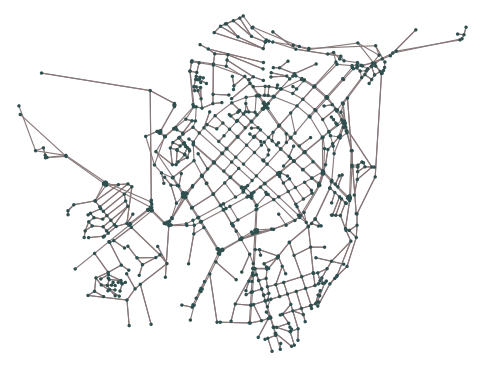

In [3]:
# ----- Build toy MultiGraph -----
PLACE = "Kentron, Yerevan, Armenia"   # small; fast for smoke tests
NETWORK = "drive"

# ---------- download (simplify=True by default here) ----------
G = ox.graph.graph_from_place(PLACE, network_type=NETWORK, simplify=True)

# keep only the largest connected component (weak is fine for roads)
G = ox.truncate.largest_component(G, strongly=False)

keep_node = {"x", "y", "street_count"}
keep_edge = {"length", "highway", "name", "maxspeed"}

for _, d in G.nodes(data=True):
    for k in list(d.keys()):
        if k not in keep_node:
            d.pop(k, None)

for u, v, k, d in G.edges(keys=True, data=True):
    for kk in list(d.keys()):
        if kk not in keep_edge:
            d.pop(kk, None)
fig, ax = ox.plot.plot_graph(
    G,
    figsize=(6, 6),
    bgcolor="white",
    node_color="#2f4f4f",
    node_size=6,
    edge_color="#877778",
    edge_linewidth=0.8,
    show=False,
    close=False,
)

### A* Search

In [6]:
G.nodes

NodeView((256031437, 256036885, 256036887, 256036890, 256037322, 256039532, 256039693, 256039716, 287884652, 287884653, 287884654, 287884828, 287884830, 287884832, 287884954, 288938475, 288938493, 288938528, 288938551, 288938556, 288938564, 288948038, 288948909, 288948937, 288948975, 288949184, 288949344, 293017675, 293017726, 293017793, 293017795, 293017796, 293017863, 293017959, 293018478, 293018568, 308879626, 310482489, 310482505, 310482521, 310482523, 310482524, 310482528, 310482529, 310482532, 310482533, 310482534, 310482539, 310482570, 311001863, 311001864, 311002049, 311002325, 311002720, 311005471, 311005589, 311005601, 311005885, 311005892, 311006013, 311006521, 311009595, 311009689, 311009691, 311009744, 311009806, 311053004, 311053005, 311053012, 311053749, 331475926, 331477916, 331489758, 331489762, 331489824, 331489827, 331489831, 331489901, 331489903, 331490150, 331525945, 331525948, 331554664, 331554775, 331554783, 331554867, 331554868, 331554869, 331554870, 331554874, 

In [7]:
# Pick valid start and goal nodes
start_node_id = list(G.nodes)[0]
goal_node_id = list(G.nodes)[564]

initial = GraphState(G, 256036887)
goal_test = SimpleGoalTest(331554874)

# Build heuristic h(state)
h = build_euclidean_heuristic(G, goal_node_id)

# Run A* graph search
astar = AStarGraphSearch()
solution_astar = astar.find_solution(initial, goal_test, h)

In [8]:
# ----- Print path -----
if solution_astar:
    path = extract_node_id_path(solution_astar)

    print("Solution path:", path)
    print("Total cost (meters):", solution_astar.path_cost)
    print("Nodes expanded:", astar.get_expanded_node_count())
else:
    print("No solution found.")

Solution path: [256036887, 3839031467, 1342409365, 4238310730, 4841692161, 407729599, 11644940326, 2271142975, 4854142869, 632031899, 11648601296, 6277581484, 6277581590, 6277581591, 10970452645, 406385836, 4688983926, 354684596, 354684574, 354684572, 10970452613, 2000420093, 7468224364, 11644952741, 407729575, 4209742296, 256037322, 388114216, 6476299245, 13141908471, 10831782329, 10830785385, 4685816051, 4758463192, 10832112969, 10832112968, 4757620715, 3913317433, 331554664, 5253976465, 1888096156, 388093148, 331554874]
Total cost (meters): 3901.9164733430084
Nodes expanded: 762


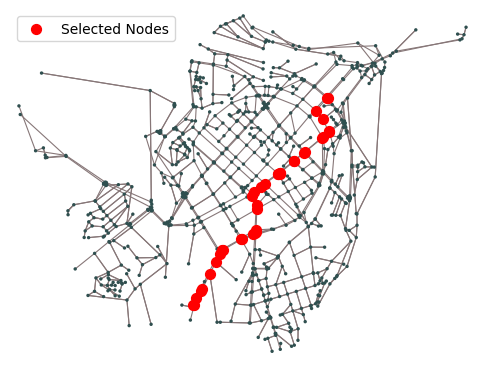

In [23]:
x_coords = [G.nodes[n]["x"] for n in path if n in G.nodes]
y_coords = [G.nodes[n]["y"] for n in path if n in G.nodes]

# replot with highlight
fig, ax = ox.plot.plot_graph(
    G,
    figsize=(6, 6),
    bgcolor="white",
    node_color="#2f4f4f",
    node_size=6,
    edge_color="#877778",
    edge_linewidth=0.8,
    show=False,
    close=False,
)

# plot the chosen nodes in red
ax.scatter(x_coords, y_coords, c="red", s=50, zorder=5, label="Selected Nodes")
ax.legend()

### Bidirectional Search

In [24]:
# Pick valid start and goal nodes
start_node_id = list(G.nodes)[0]
goal_node_id = list(G.nodes)[564]

initial = GraphState(G, start_node_id)
goal_test = SimpleGoalTest(goal_node_id)

# Run Bidirectional graph search
bidirectional = BidirectionalGraphSearch()
solution_bidirectional = bidirectional.find_solution(initial, goal_test)

In [25]:
# ----- Print path -----
if solution_bidirectional:
    path = extract_node_id_path(solution_bidirectional)
    print("Solution path:", path)
    print("Total cost (meters):", solution_bidirectional.path_cost)
    print("Nodes expanded:", bidirectional.get_expanded_node_count())
else:
    print("No solution found.")

Solution path: [256031437, 5026483106, 5026483105, 5009318171, 10831681874, 1475774820, 1807998351, 5118314365, 10831688447, 8913362246, 5035725114, 5026483107, 9280261372, 5489385514, 9227012882, 5489385511, 5450648349, 4296905827, 12593950281, 10970452605, 407729613, 632031882, 6277581589, 2420195983, 6277581586, 6277581587, 3831529185, 11648601295, 11648561414, 11648561419, 11648561420, 11644940327, 11648561426, 11648561428, 407729599, 1970926499, 4110471701, 4110471700, 4234582615]
Total cost (meters): 3593.7360494207596
Nodes expanded: 1400


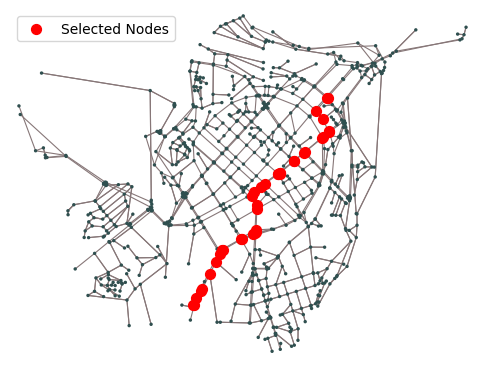

In [26]:
x_coords = [G.nodes[n]["x"] for n in path if n in G.nodes]
y_coords = [G.nodes[n]["y"] for n in path if n in G.nodes]

# replot with highlight
fig, ax = ox.plot.plot_graph(
    G,
    figsize=(6, 6),
    bgcolor="white",
    node_color="#2f4f4f",
    node_size=6,
    edge_color="#877778",
    edge_linewidth=0.8,
    show=False,
    close=False,
)

# plot the chosen nodes in red
ax.scatter(x_coords, y_coords, c="red", s=50, zorder=5, label="Selected Nodes")
ax.legend()